Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Data Reading/Data Understanding

#### Importing Libraries

In [1]:
# Warnings library will be used to ignore some warnings
import warnings
warnings.filterwarnings('ignore')

# Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D , BatchNormalization

#### Importing Dataset

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


#### Defined the path for both train and test images from dataset.

In [3]:
root_path = "/content/gdrive/MyDrive/"
if os.path.exists(root_path + "CNN_assignment"):
  root_path  = root_path + "CNN_assignment/"
  print("Input folder found.")
elif os.path.isfile(root_path + "CNN_assignment.zip"):
  print("zip folder found. unzipping...")
  from zipfile import ZipFile
  with ZipFile(root_path + "CNN_assignment.zip",'r') as zipObj:
    zipObj.extractall(root_path + "CNN_assignment")
    root_path  = root_path + "CNN_assignment/"
    print("Input folder extracted.")
else:
  print("Input folder not found.")

Input folder found.


In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = root_path + "Skin cancer ISIC The International Skin Imaging Collaboration/"
data_dir_train = pathlib.Path(root_path + '/Train/')
data_dir_test = pathlib.Path(root_path + '/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Dataset Creation

#### Define some parameters for the loader:

In [6]:
## specify input dimensions of each image
img_height, img_width = 180, 180
input_shape = (img_height, img_width, 3)

# batch size, number of classes, epochs
batch_size = 32
num_classes = 9
epochs = 20

##  For optimser using Adam optimization and for loss function using categorical_crossentropy.
adam_optimizer = 'adam'
sparse_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cat_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

#### Use 80% of the images for training, and 20% for validation.

In [7]:
## Creating train dataset with seed=123 and size img_height * img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Creating validation dataset with seed=123 and size img_height * img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Dataset Visualisation

#### Visualize one instance of all the class present in the dataset

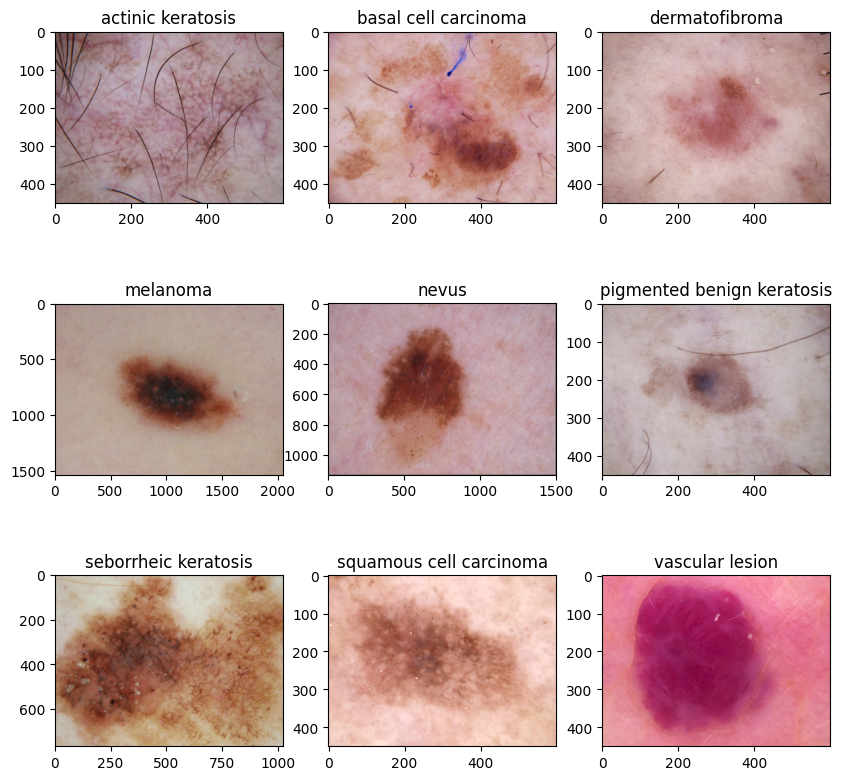

In [10]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [11]:
## tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.
AUTOTUNE = tf.data.experimental.AUTOTUNE

## 'Dataset.cache()' keeps the images in memory after they're loaded off disk during the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## 'Dataset.prefetch()' overlaps data preprocessing and model execution while training.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & Training

### Creating CNN model

In [12]:
## The RGB channel values are in the '[0, 255]' range. This is not ideal for a neural network.
## It is good to standardize values to be in the '[0, 1]'
## Hence using 'layers.experimental.preprocessing.Rescaling' to normalize pixel values between (0,1).
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

#1st Convulation layer
model.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2)))

#2nd Convulation Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#3th Convulation Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#Flatten Layer (Flattens the multi-dimensional input tensors into a single dimension)
model.add(Flatten())

#Dense Layer wtih 512 neurons
model.add(Dense(512,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(Dropout(0.25))

#Dense Layer with softmax activation function (which scales numbers/logits into probabilities.)
model.add(Dense(num_classes, activation="softmax"))

### Compiling the model

In [13]:
model.compile(optimizer=adam_optimizer,loss=sparse_loss_fn, metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Training the model for ~20 epochs

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 430s 2s/step - loss: 2.1250 - accuracy: 0.2288 - val_loss: 1.7763 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 4s 71ms/step - loss: 1.7434 - accuracy: 0.3627 - val_loss: 1.6056 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5530 - accuracy: 0.4347 - val_loss: 1.5358 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4763 - accuracy: 0.4754 - val_loss: 1.4490 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 4s 71ms/step - loss: 1.3366 - accuracy: 0.5407 - val_loss: 1.3844 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.2602 - accuracy: 0.5586 - val_loss: 1.3535 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.1608 - accuracy: 0.5977 - val_loss: 1.3830 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing training results

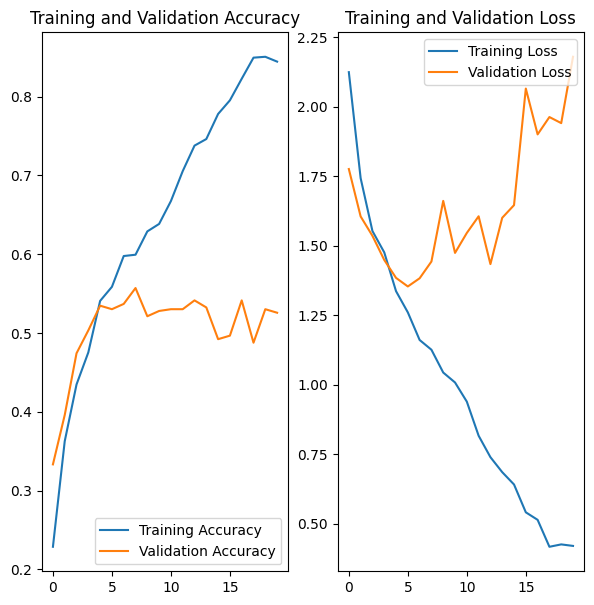

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(7, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Findings after the model fit

- There is high diffrence between the training accuracy and validation accuracy which is a clear sign of overfiting.
- The training accuracy of the model is also not very good.

## Data Augmentation

In [16]:
# Define the data augmentation transformations
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


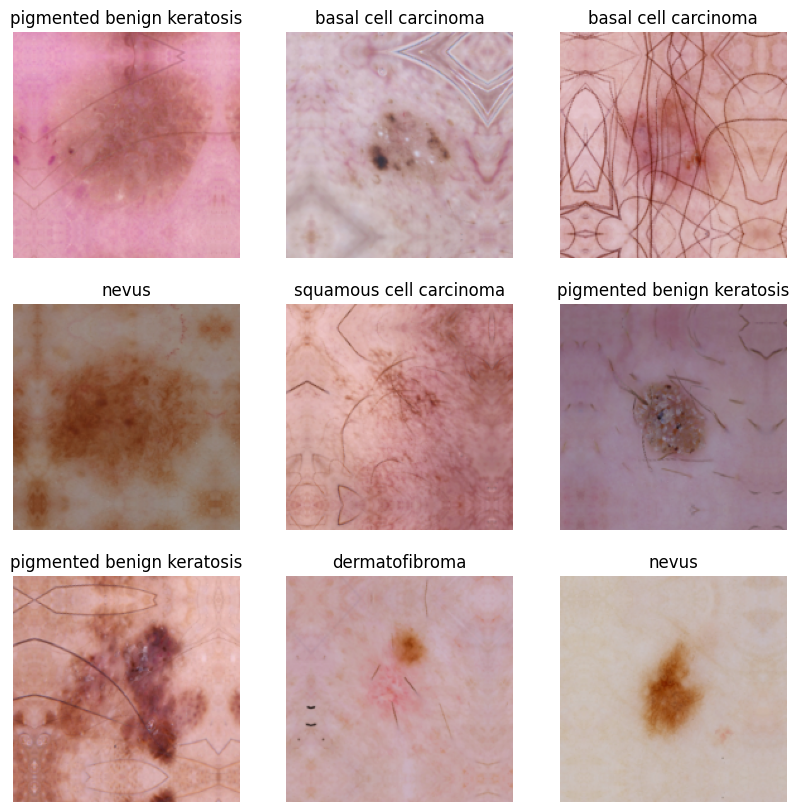

In [17]:
## visualizing augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(num_classes):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Building & Training With Data Augmentation

### Creating CNN model (using Dropout layer)

In [18]:
model2 = Sequential([data_augument,tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

#1st Convulation layer
model2.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model2.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

#2nd Convulation Layer
model2.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

#3rd Convulation Layer
model2.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))


#Flatten Layer (Flattens the multi-dimensional input tensors into a single dimension)
model2.add(Flatten())
#Dense Layer wtih 512 neurons
model2.add(Dense(512,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model2.add(Dropout(0.25))
#Dense Layer with softmax activation function (which scales numbers/logits into probabilities.)
model2.add(Dense(num_classes, activation="softmax"))

### Compiling the model

In [19]:
model2.compile(optimizer=adam_optimizer,loss=sparse_loss_fn, metrics=['accuracy'])

# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                      

### Training the model for ~20 epochs.

In [20]:
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 102ms/step - loss: 2.5476 - accuracy: 0.2143 - val_loss: 2.0001 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 6s 99ms/step - loss: 1.7980 - accuracy: 0.3605 - val_loss: 1.8198 - val_accuracy: 0.3110
Epoch 3/20
56/56 [==============================] - 6s 101ms/step - loss: 1.6854 - accuracy: 0.3850 - val_loss: 1.6343 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 6s 100ms/step - loss: 1.6612 - accuracy: 0.3917 - val_loss: 1.6282 - val_accuracy: 0.4318
Epoch 5/20
56/56 [==============================] - 6s 102ms/step - loss: 1.5962 - accuracy: 0.4213 - val_loss: 1.5775 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 6s 102ms/step - loss: 1.5579 - accuracy: 0.4520 - val_loss: 1.5544 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 6s 99ms/step - loss: 1.5742 - accuracy: 0.4414 - val_loss: 1.5466 - val_accuracy: 0.4385
Epoch 8/

### Visualizing training results

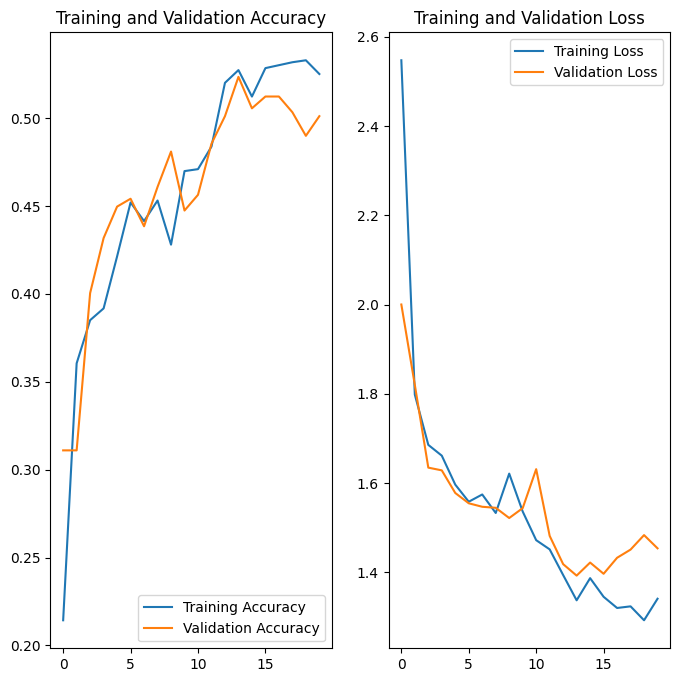

In [21]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit

- The problem of overfiting is solved due to data augmentation.
- The training accuracy of the model is still not very good.

## Class Distribution

Finding the distribution of classes in the training dataset. As many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                        Class  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


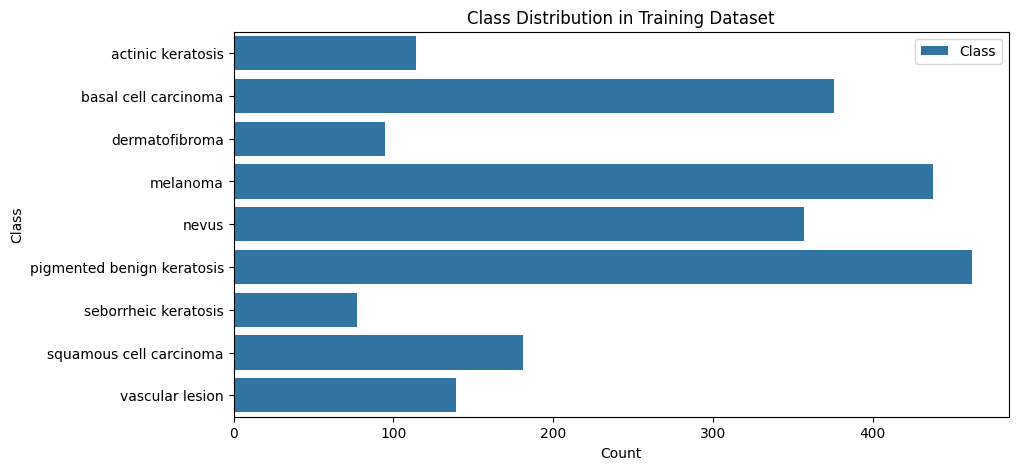

In [22]:
## Initialize a dictionary to store the count of images in each class
class_counts = {}

## Count the number of images in the class directory
for class_name in class_names:
  class_path = os.path.join(data_dir_train, class_name)
  num_images = len(os.listdir(class_path))
  class_counts[class_name] = num_images

## Convert the dictionary to a DataFrame for easier analysis
df_class_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
print(df_class_counts)

## Visualize the Distribution
plt.figure(figsize=(10, 5))
sns.barplot( x='Count' ,y='Class' , data=df_class_counts,label='Class')
plt.title('Class Distribution in Training Dataset')
plt.show()

### Findings after checking class distribution
#### 1) Which class has the least number of samples?
- seborrheic keratosis

#### 2) Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis, melanoma and basal cell carcinoma


## Handling Class Imbalances

In [23]:
## Adding a package known as 'Augmentor' to add more samples across all classes so that none of the classes have very few samples.
try:
    import Augmentor
except ImportError as e:
    ## Installing python package known as Augmentor
    !pip install Augmentor
    import Augmentor

In [24]:
path_to_training_dataset = data_dir_train
for class_name in class_names:
    class_path = str(path_to_training_dataset) + "/" + class_name
    p = Augmentor.Pipeline(class_path,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E83FBEF37C0>: 100%|██████████| 500/500 [00:23<00:00, 21.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E83F85CAAD0>: 100%|██████████| 500/500 [00:23<00:00, 21.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E83FBE4B400>: 100%|██████████| 500/500 [00:20<00:00, 24.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8422132EF0>: 100%|██████████| 500/500 [01:35<00:00,  5.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x671 at 0x7E83FBD6A230>: 100%|██████████| 500/500 [01:23<00:00,  5.98 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E83F85CAB30>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E847E513310>: 100%|██████████| 500/500 [00:41<00:00, 12.14 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E83FC1860E0>: 100%|██████████| 500/500 [00:18<00:00, 27.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E83FBE8C070>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
## Creating dataframe containing the path and label of augmented data
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_output_dict = dict(zip(path_list_new, lesion_list_new))
dataframe_output = pd.DataFrame(list(dataframe_output_dict.items()),columns = ['Path','Label'])

## Creating dataframe containing the path and label of origiral data
path_list = [x for x in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
original_df_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(original_df_dict.items()),columns = ['Path','Label'])

## merging both original and augmented dataframe
new_df = pd.concat([original_df, dataframe_output], ignore_index=True)

## Checking the output
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Model Building & Training With Augmentor

### New data creation

In [27]:
## Creating train dataset with seed=123 and size img_height * img_width
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [28]:
## Creating validation dataset with seed=123 and size img_height * img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creating CNN model (including normalization)

In [29]:
model3 = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape)])

#1st Convulation layer
model3.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model3.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation ='relu', input_shape=input_shape))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())
#Dropout layer with 25% Fraction of the input units to drop.
model3.add(Dropout(0.25))

#2nd Convulation Layer
model3.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation ='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())
#Dropout layer with 25% Fraction of the input units to drop.
model3.add(Dropout(0.25))

#3rd Convulation Layer
model3.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation ='relu'))
model3.add(MaxPool2D(pool_size=(2,2)))
model3.add(BatchNormalization())
#Dropout layer with 25% Fraction of the input units to drop.
model3.add(Dropout(0.25))


#Flatten Layer (Flattens the multi-dimensional input tensors into a single dimension)
model3.add(Flatten())
#Dense Layer wtih 512 neurons
model3.add(Dense(512,activation='relu'))
#Dropout layer with 25% Fraction of the input units to drop.
model3.add(Dropout(0.25))
#Dense Layer with softmax activation function (which scales numbers/logits into probabilities.)
model3.add(Dense(num_classes, activation="softmax"))

### Compiling the model

In [30]:
model3.compile(optimizer=adam_optimizer,loss=sparse_loss_fn, metrics=['accuracy'])

# View the summary of all layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 90, 90, 32)        128       
 Normalization)                                                  
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)       

### Training the model for ~30 epochs

In [31]:
epochs = 30
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 63s 335ms/step - loss: 3.6110 - accuracy: 0.2559 - val_loss: 7.7776 - val_accuracy: 0.0898
Epoch 2/30
169/169 [==============================] - 46s 268ms/step - loss: 1.7953 - accuracy: 0.3121 - val_loss: 4.3450 - val_accuracy: 0.1774
Epoch 3/30
169/169 [==============================] - 46s 265ms/step - loss: 1.7038 - accuracy: 0.3513 - val_loss: 1.9759 - val_accuracy: 0.3170
Epoch 4/30
169/169 [==============================] - 47s 264ms/step - loss: 1.6546 - accuracy: 0.3800 - val_loss: 1.9332 - val_accuracy: 0.2977
Epoch 5/30
169/169 [==============================] - 47s 264ms/step - loss: 1.5512 - accuracy: 0.3984 - val_loss: 1.7187 - val_accuracy: 0.3719
Epoch 6/30
169/169 [==============================] - 47s 271ms/step - loss: 1.5163 - accuracy: 0.4023 - val_loss: 1.8893 - val_accuracy: 0.3601
Epoch 7/30
169/169 [==============================] - 45s 261ms/step - loss: 1.4730 - accuracy: 0.4188 - val_loss: 1.8614 - val_ac

### Visualizing training results

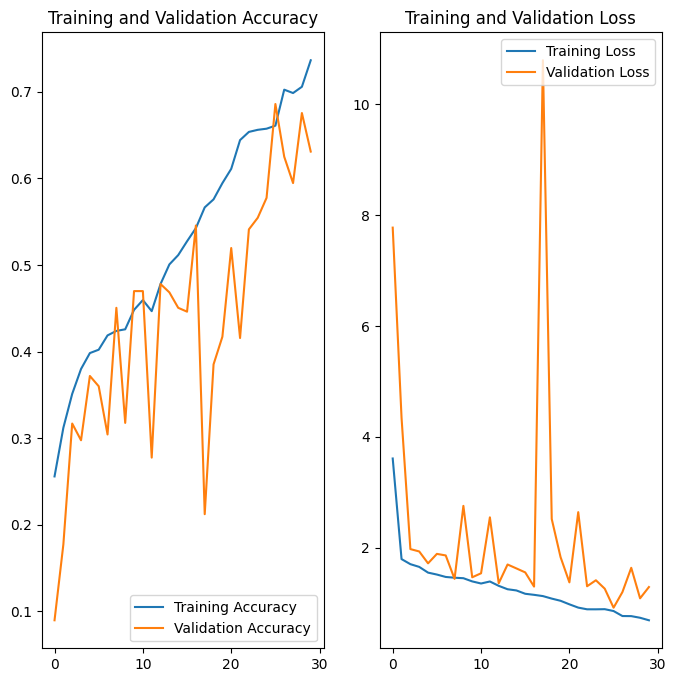

In [32]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after the model fit

- The model is still overfiting which can be solved by adding more layers, neurons or dropout layers.
- The training accuracy of the model is still not very good but it can be increased with the help of hyperparameter tuning.